In [1]:
path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'

# Libraries

In [2]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import cv2
import timeit
import numpy as np 
import pandas as pd
from PIL import Image
from tensorflow import keras
import tensorflow as tf
from keras import Model
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization,Conv2D,Dense,Activation,Conv2DTranspose,Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D,Concatenate

In [5]:
def num (image) :
    val = 0
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    return val

In [3]:
X_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_m, y_m= np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [6]:
for i, tumor_type in enumerate(os.listdir(path)) :
    for image in os.listdir(path+tumor_type+'/') :
        p = os.path.join(path+tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # read image as  grayscale
        
        if image[-5] == ')' :
            
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                X_b[num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                           # to X as benign , normal
                X_n[num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[num(image)-1]+= img_to_array(pil_img)
        else :
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                y_b[num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                           # mask to y.
                y_n[num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                y_m[num(image)-1]+= img_to_array(pil_img)

In [7]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

In [8]:
print(X.shape)
print(y.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


In [9]:
def convertToOneChannel(img):
    im=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    i=cv2.resize(im, (128, 128))
    return i

In [10]:
def convertToThreeChannel(img):
    b_np= np.array(img)
    g_np= np.array(img)
    r_np= np.array(img)
    final_img = np.dstack([b_np, g_np, r_np]).astype(np.uint8)
    return np.array(final_img)

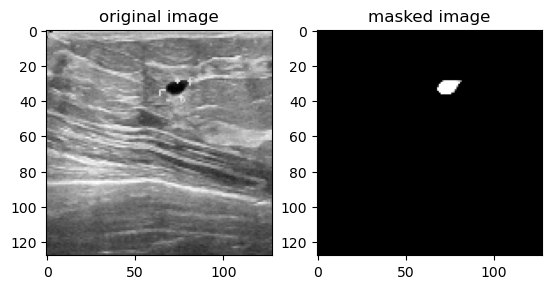

In [11]:
img=convertToThreeChannel(X[10])
mask=convertToThreeChannel(y[10])
plt.figure
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("masked image")
plt.show()

In [12]:
actual=[]
mask=[]
for i in X:
    horizontal_flip = cv2.flip(i, 1)
    vertical_horizontal_flip = cv2.flip(i, -1)
    imagerotate = cv2.rotate(i, cv2.ROTATE_180) 
    imagerotate1 = cv2.rotate(i, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate2 = cv2.rotate(i, cv2.ROTATE_90_CLOCKWISE)
    actual.append(horizontal_flip)
    actual.append(vertical_horizontal_flip)
    actual.append(imagerotate)
    actual.append(imagerotate1)
    actual.append(imagerotate2)

for j in y:
    horizontal_flip_mask = cv2.flip(j, 1)
    vertical_horizontal_flip_mask = cv2.flip(j, -1)
    imagerotate_mask1 = cv2.rotate(j, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate_mask = cv2.rotate(j, cv2.ROTATE_180)
    imagerotate_mask2 = cv2.rotate(j, cv2.ROTATE_90_CLOCKWISE)
    mask.append(horizontal_flip_mask)
    mask.append(vertical_horizontal_flip_mask)
    mask.append(imagerotate_mask)
    mask.append(imagerotate_mask1)
    mask.append(imagerotate_mask2)    

In [13]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [14]:
actual=actual/255
mask=mask/255
print(mask.max())
print(mask.min())

2.0
0.0


In [15]:
mask[mask > 1.0] = 1.0

In [16]:
print(mask.max())
print(mask.min())

1.0
0.0


In [17]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [18]:
t1=np.full(2185,1) 
t2=np.full(665,0)
t3=np.full(1050,2)  
T=np.concatenate((t1, t2, t3), axis = 0)
T=np.array(T)

In [19]:
print(T.shape)

(3900,)


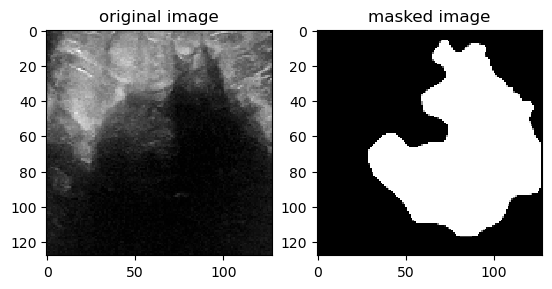

In [20]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(actual[3000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask[3000],interpolation='nearest',cmap='gray')
plt.title("masked image")
plt.show()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(actual, mask, test_size = 0.15, random_state = 1)

In [22]:
actual1=[]
for i in actual:
    actual1.append(convertToThreeChannel(i) )
mask1=[]
for i in mask:
    mask1.append(convertToThreeChannel(i) )
actual1=np.array(actual1)
mask1=np.array(mask1)

In [23]:
print(X_train.shape)
print(X_test.shape)

(3315, 128, 128)
(585, 128, 128)


In [24]:
inply = Input((128, 128, 1,))

conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(inply)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)

In [25]:
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)

In [26]:
tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)

In [27]:
outly = Conv2D(2**0, (1,1), activation = 'relu', padding = 'same')(drop8)
model = Model(inputs = inply, outputs = outly, name = 'U-net')

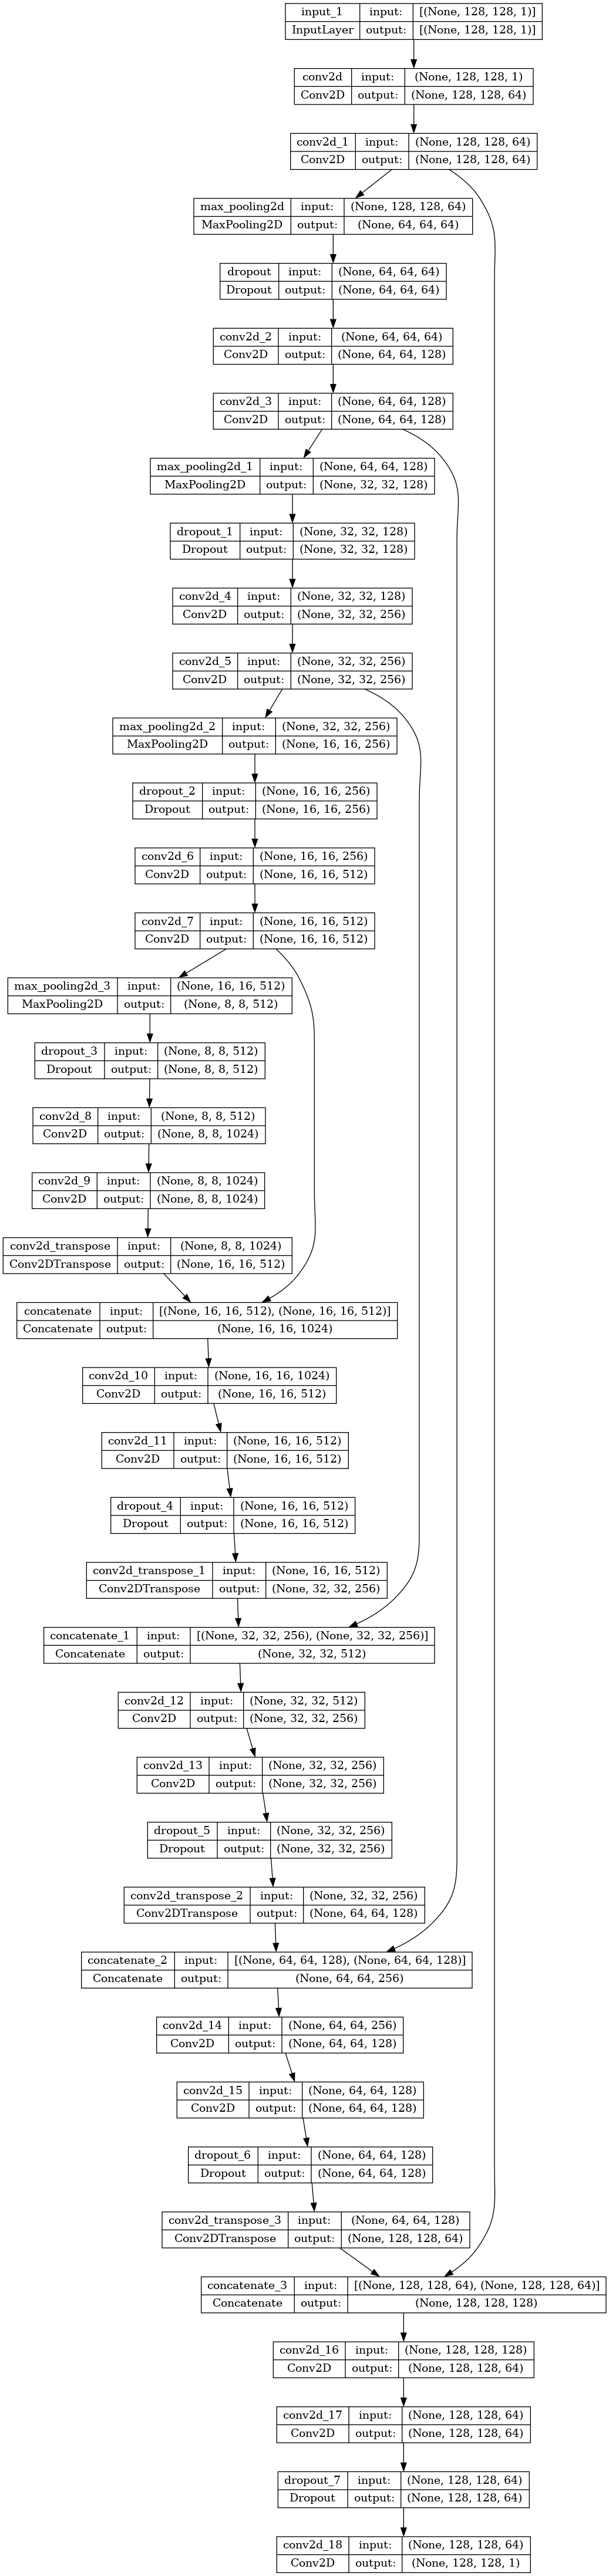

In [28]:
keras.utils.plot_model(model, './model_plot.png', show_shapes = True)

In [29]:
from keras.metrics import MeanIoU

In [30]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005),metrics=['acc'])
print(model.summary())

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [31]:
from keras.callbacks import ModelCheckpoint

In [32]:
checkp = ModelCheckpoint('./unet_model.h5', monitor = 'accuracy', save_best_only = True, verbose = 1)

In [33]:
history = model.fit(X_train, y_train, epochs = 200, batch_size = 16, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/200


2023-06-29 10:41:12.833679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


208/208 [==============================] - 46s 143ms/step - loss: 0.0672 - acc: 0.9210 - val_loss: 0.0516 - val_acc: 0.9349
Epoch 2/200
208/208 [==============================] - 27s 131ms/step - loss: 0.0534 - acc: 0.9316 - val_loss: 0.0499 - val_acc: 0.9345
Epoch 3/200
208/208 [==============================] - 27s 131ms/step - loss: 0.0468 - acc: 0.9387 - val_loss: 0.0476 - val_acc: 0.9377
Epoch 4/200
208/208 [==============================] - 27s 131ms/step - loss: 0.0434 - acc: 0.9429 - val_loss: 0.0394 - val_acc: 0.9462
Epoch 5/200
208/208 [==============================] - 27s 131ms/step - loss: 0.0404 - acc: 0.9477 - val_loss: 0.0360 - val_acc: 0.9526
Epoch 6/200
208/208 [==============================] - 27s 131ms/step - loss: 0.0366 - acc: 0.9531 - val_loss: 0.0309 - val_acc: 0.9607
Epoch 7/200
208/208 [==============================] - 27s 131ms/step - loss: 0.0337 - acc: 0.9568 - val_loss: 0.0293 - val_acc: 0.9628
Epoch 8/200
208/208 [==============================] - 27s 1

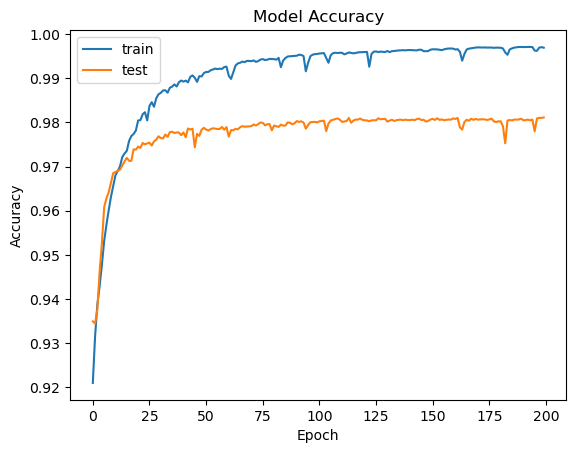

In [34]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

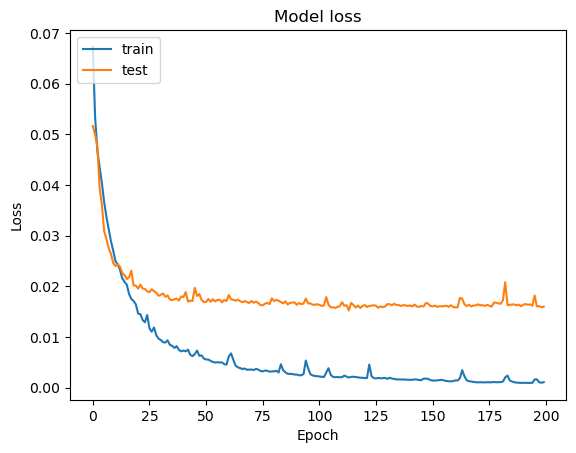

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
score = model.evaluate(X_test, y_test, verbose = 1) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]*100)

19/19 [==============================] - 4s 56ms/step - loss: 0.0160 - acc: 0.9811
Test loss: 0.01596011593937874
Test accuracy: 98.11010360717773


In [54]:
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8730732


In [43]:
len(y_test)

585

In [71]:
y_test = np.squeeze(y_test)

In [75]:
y_pred = np.squeeze(y_pred)

In [76]:
y_pred.shape

(585, 128, 128)

In [72]:
y_test.shape

(585, 128, 128)

In [78]:
import numpy as np

def dice_coefficient(y_pred, y_test, smooth = 1e-5):
    
    intersection = np.sum(y_pred * y_test)
    union = np.sum(y_pred) + np.sum(y_test)
    
    dice= 2.0 * (intersection + smooth) / (union + smooth)     # Adding a small value to avoid division by zero
    return dice

y_pred=model.predict(X_test,verbose=0)
y_pred = np.squeeze(y_pred)
dice_score = dice_coefficient(y_pred, y_test)
print("Dice coefficient:", dice_score)


Dice coefficient: 0.865648968883025


In [79]:
model.save("./finalunet.h5")

In [80]:
def imgpredicting(img):
    x=[]
    x.append(img)
    x=np.array(x)
    output=model.predict(x)
    #print(output)
    output=np.array(output)
    output.shape
    array = np.reshape(output[0], (128, 128))
    print(array.shape)
    return array

1/1 [==============================] - 0s 352ms/step
(128, 128)


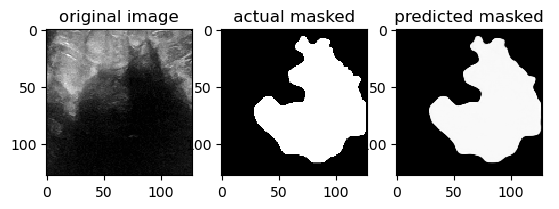

In [39]:
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[3000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[3000],interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[3000]),interpolation='nearest',cmap='gray')
plt.title(" predicted masked ")
plt.show()

In [93]:
import numpy as np
rndImgs=np.random.choice(len(X_test),4)
rndImgs

array([475, 577, 352, 463])

1/1 [==============================] - 0s 37ms/step
(128, 128)


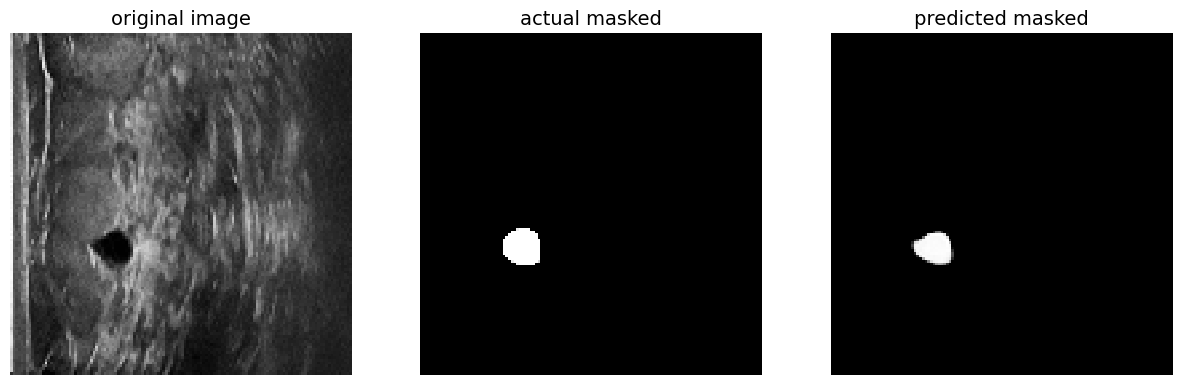

1/1 [==============================] - 0s 23ms/step
(128, 128)


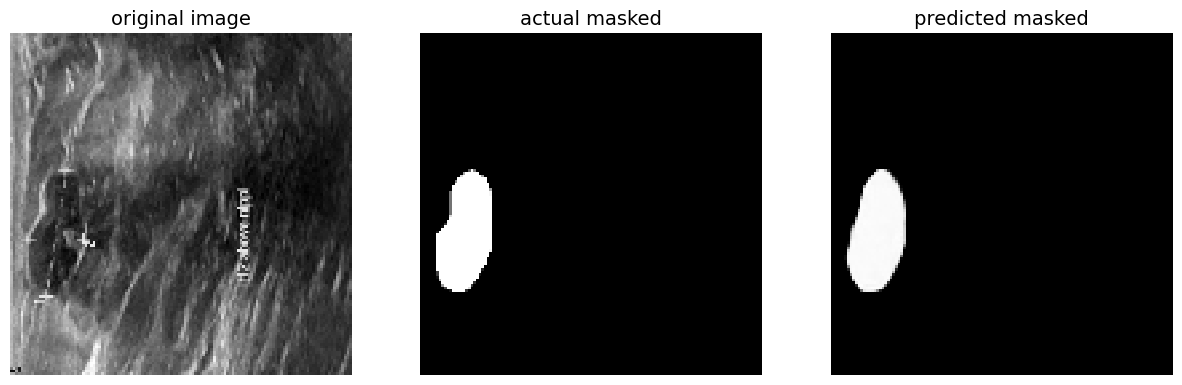

1/1 [==============================] - 0s 26ms/step
(128, 128)


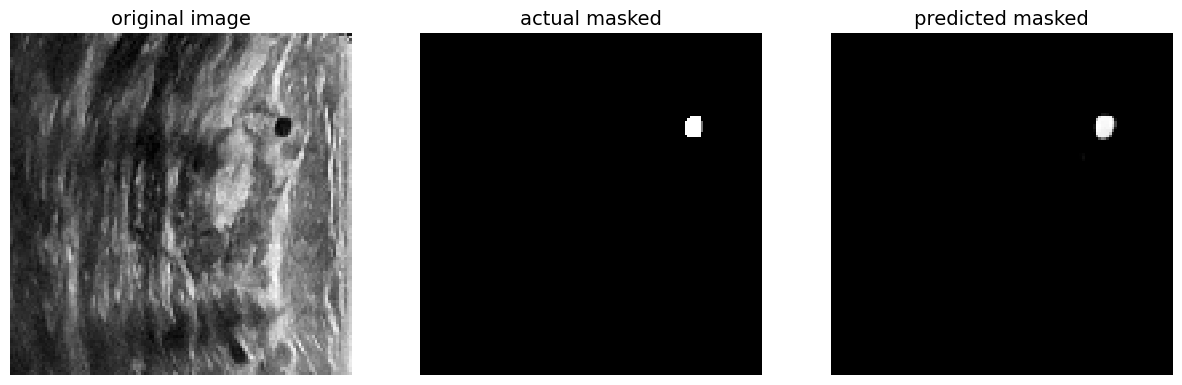

1/1 [==============================] - 0s 25ms/step
(128, 128)


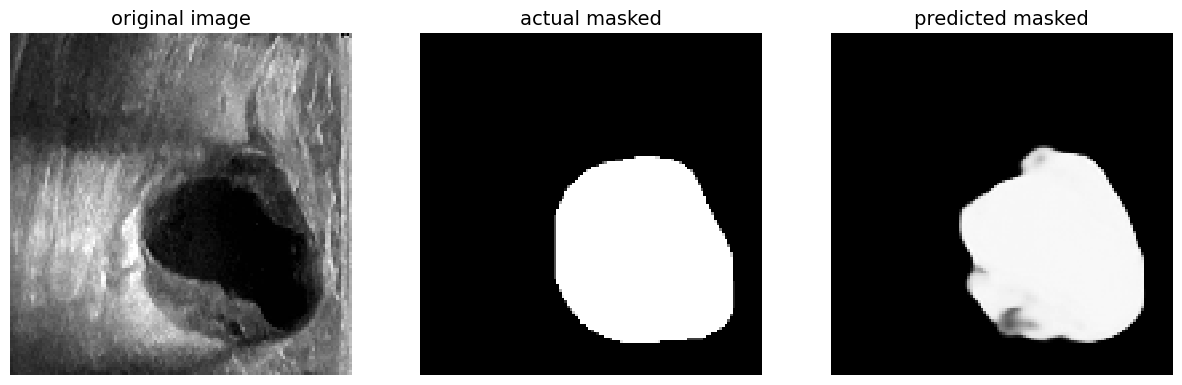

In [113]:
for fn in rndImgs:
    
    plt.figure(figsize=(15, 5))
    
    plt.figure
    plt.subplot(1,3,1)
    plt.imshow(X_test[fn],interpolation='nearest',cmap='gray')
    plt.title("original image", fontsize = 14)
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(y_test[fn],interpolation='nearest',cmap='gray')
    plt.title(" actual masked ",  fontsize = 14)
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(imgpredicting(X_test[fn]),interpolation='nearest',cmap='gray')
    plt.title(" predicted masked ",  fontsize = 14)
    plt.axis('off')
    
    plt.show()

In [106]:
def CalculateTumorSize(mask_pred):
    thresh = skimage.filters.threshold_otsu(mask_pred)
    tumor_mask = mask_pred > thresh
    
    pixel_size = 0.1  # the size of a pixel in millimeters
    label_image = skimage.measure.label(tumor_mask)
    region_props = skimage.measure.regionprops(label_image)
    
    if len(region_props) == 0:
        tumor_size_mm = 0.0
    else:
        tumor_area = region_props[0].area
        tumor_size_mm = tumor_area * pixel_size ** 2
        
    return tumor_size_mm

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from PIL import Image

def show_img_mask(img, mask):
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img.astype(np.uint8))
    if isinstance(mask, np.ndarray):
        mask = Image.fromarray((mask * 255).astype(np.uint8))

    img_mask = mark_boundaries(np.array(img),
                               np.array(mask),
                               outline_color=(0, 1, 0),
                               color=(0, 1, 0))
    plt.imshow(img_mask)
    plt.title(f"Predicted Tumor Size: {tumor_size_mm:.2f} mm^2", fontsize=14)
    plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 40ms/step
(128, 128)


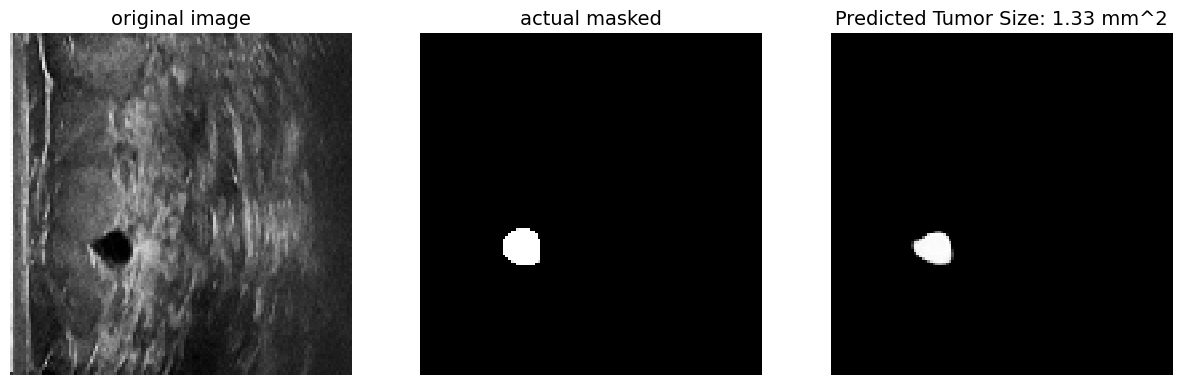

1/1 [==============================] - 0s 28ms/step
(128, 128)


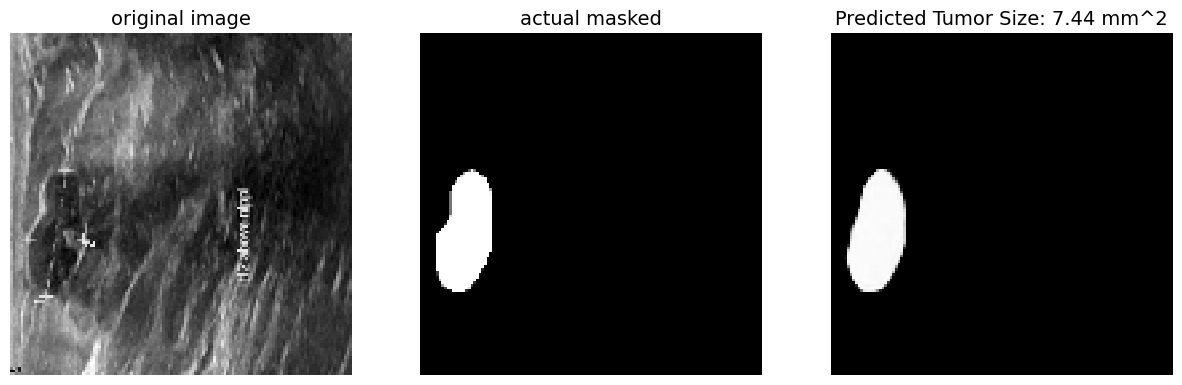

1/1 [==============================] - 0s 42ms/step
(128, 128)


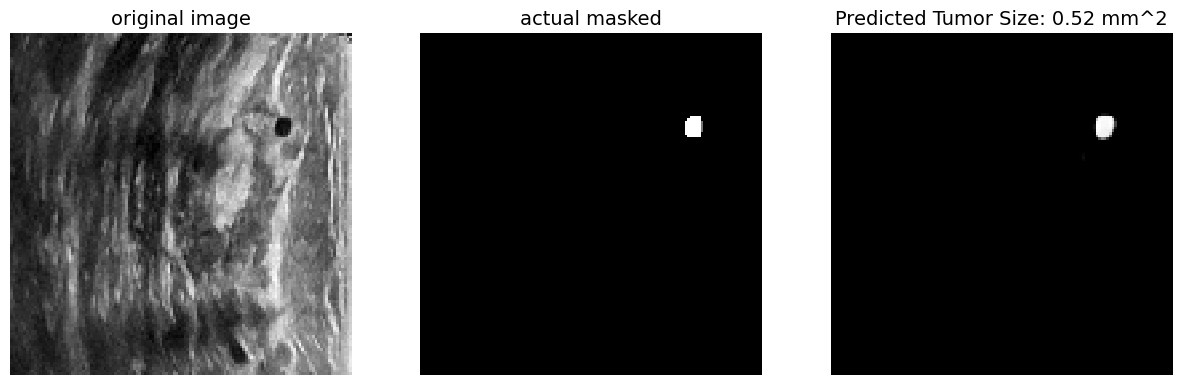

1/1 [==============================] - 0s 41ms/step
(128, 128)


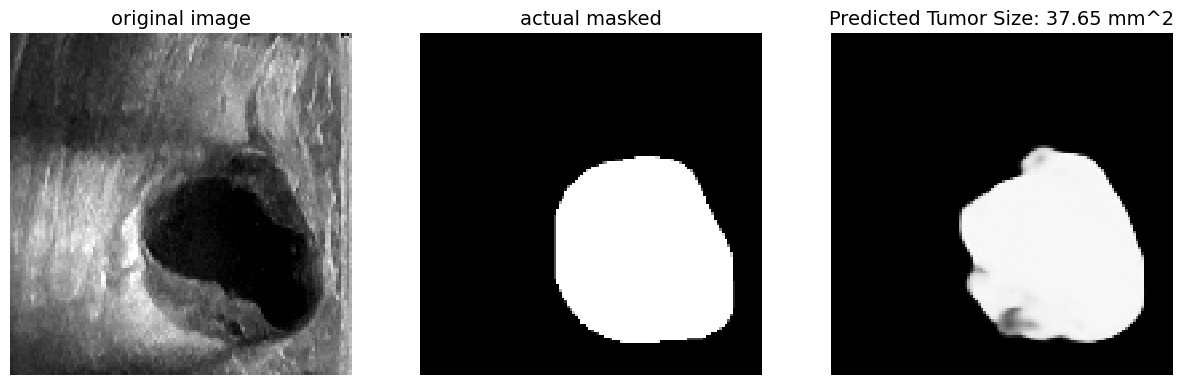

In [146]:
import skimage.filters
import skimage.measure

for fn in rndImgs:
    
    mask_pred = imgpredicting(X_test[fn])
    
    plt.figure(figsize=(15, 5))
    
    plt.figure
    plt.subplot(1,3,1)
    plt.imshow(X_test[fn],interpolation='nearest',cmap='gray')
    plt.title("original image", fontsize = 14)
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(y_test[fn],interpolation='nearest',cmap='gray')
    plt.title(" actual masked ",  fontsize = 14)
    plt.axis('off')
    
    tumor_size_mm = CalculateTumorSize(mask_pred)
    plt.subplot(1, 3, 3)
    plt.imshow(mask_pred, interpolation='nearest',cmap='gray')
    plt.title(f"Predicted Tumor Size: {tumor_size_mm:.2f} mm^2", fontsize=14)
    plt.axis('off')
    
    plt.show()
